In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Random Dinosaur Names Generator with Stateful LSTM

In [2]:
import sys
sys.path.append('..')

In [3]:
#DATA_PATH = "../data/babynames-clean.csv"
DATA_PATH = "../data/dinos.txt"

In [4]:
import numpy as np
from src.utils import *
import random
import pprint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Dropout, SimpleRNN, RepeatVector, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras import regularizers, optimizers


In [5]:
data = open(DATA_PATH, 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


Example:

In [6]:
all_names =  data.split("\n")
all_names[0]

'aachenosaurus'

Number of available names:

In [7]:
len(all_names)

1536

Different characters present:

In [8]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(ix_to_char)

In [10]:
max_time_steps = max( map( lambda x: len(x), data.split("\n") ))
print(f"The max length of a name (max_num_timesteps) is {max_time_steps}")

num_features = vocab_size
print(f"The size of the character vocabulary is {num_features}")

The max length of a name (max_num_timesteps) is 26
The size of the character vocabulary is 27


# 1. Vectorize dataset (on-hot encoding)

In [11]:
test_example = all_names[0]

In [12]:
def create_one_hot(one_pos, vector_size):
    x = np.zeros( vector_size )
    x[one_pos] = 1
    return x

In [13]:
def vectorize_example(example):
    """
    example: str name
    """
    x = np.zeros((max_time_steps+1, num_features))
    
    diff_x = max_time_steps  - len(example)
    
    #x[0,:] = 0
    
    for i, c in enumerate(example):
        x[i+1, char_to_ix[c] ] = 1 
    
    i = len(example)-1
    for j in range(diff_x):
        x[j+i+2, char_to_ix['\n']] = 1       
        
    y = np.vstack( (x[1:], create_one_hot(char_to_ix['\n'], num_features)))
    
    return x, y


In [14]:
x, y = vectorize_example(test_example)

In [15]:
#print(x.shape, y.shape)

In [16]:
def devectorize_example(example): 
    result = [ix_to_char[np.argmax(vec)] for vec in example]
    return ''.join(result)

In [17]:
#devectorize_example(y)

In [18]:
#devectorize_example(x)

# 2. Create vectorized dataset

In [19]:
def create_vectorized_dataset(data):
    """
    data must be a list of name strings.
    """
    num_examples = len(data)
    
    X = np.zeros((num_examples, max_time_steps+1, num_features))
    Y = np.zeros((num_examples, max_time_steps+1, num_features))
    
    for i, example in enumerate(data):
        #print(example)
        x_i, y_i = vectorize_example(example)
        X[i] = x_i
        Y[i] = y_i
        
    return X , Y

X,Y = create_vectorized_dataset(all_names)

# 3. Create the model

In [20]:
def sample(model, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    model -- RNN keras model
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- random seed.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """

    
    # Step 1: Create the a zero vector x that can be used as the one-hot vector 
    # representing the first character (initializing the sequence generation). (≈1 line)
    ix = np.random.randint(0,vocab_size)
    x = np.zeros((1, 1, num_features))
    #x[:, : ,ix] = 1
        
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # We will initialize idx to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step:
    # sample a character from a probability distribution 
    # and append its index (`idx`) to the list "indices". 
    # We'll stop if we reach 50 characters 
    # (which should be very unlikely with a well trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    counter = 0
    newline_character = char_to_ix['\n']

    while (idx != newline_character and counter != 50): # and idx != empty_character):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        y = model.predict(x)

        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)
        idx = np.random.choice(list(range(vocab_size)), p = np.ravel(y))

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
        # (see additional hints above)
        x = np.zeros((1, 1, num_features))
        x[:, : ,idx] = 1 
        
        # Update "a_prev" to be "a"
        #keras model with stateful = True
        
        seed += 1
        counter +=1
        
    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [21]:
def get_new_model(hidden_units = 50,
                  max_time_steps = max_time_steps,
                  num_features = num_features
                 ):
    
    model = Sequential([
        LSTM(hidden_units,
                           kernel_regularizer = regularizers.l2(1e-4), return_sequences = True, 
                      input_shape = (None, num_features), batch_size = 1, stateful = True),
        Dropout(0.2),
        LSTM(hidden_units, input_shape = (None, hidden_units),
             kernel_regularizer = regularizers.l2(1e-4), return_sequences = True,
             stateful = True),
        Dropout(0.1),
        Dense(num_features, activation = 'softmax')
    ])

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizers.Adam(learning_rate=0.001
                                   , clipvalue=0.1),
        metrics = ['accuracy']
    )
    
    return model

In [22]:
model = get_new_model()

Summary of the model

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 50)             15600     
_________________________________________________________________
dropout (Dropout)            (1, None, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (1, None, 50)             0         
_________________________________________________________________
dense (Dense)                (1, None, 27)             1377      
Total params: 37,177
Trainable params: 37,177
Non-trainable params: 0
_________________________________________________________________


## 3.1 Train the model

In [24]:
def print_N_examples(N, e):
    if e % 10 == 0 or e is None:
        if e is not None:
            print(f"\nExamples epoch {e}:")
            
        examples = ''

        for i in range(N):
            spl = sample(model, char_to_ix, seed=i)
            try:                
                ex_i = f"\t {i+1}) " + print_sample(spl, ix_to_char, retrn = True)
            except:
                ex_i = f"\t {i+1}) " + "error when printing the example"
                continue
                
            examples = examples + ex_i
        print(examples)
    
def print_train_logs(e, l):
    if e % 10 == 0:
        print(f"Epoch {e}. loss: {l['loss']:.3f} - accuracy: {l['accuracy']:.3f} - val_loss: {l['val_loss']:.3f} - val_accuracy: {l['val_accuracy']:.3f}")        

In [25]:
l_cb = LambdaCallback(
    on_epoch_end = lambda e, l: print_N_examples(5, e), end = '\n'
)


logs_cb = LambdaCallback(
    on_epoch_end = lambda e, l: print_train_logs(e, l), end = '\n'
)

es_cb = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = True)

callbacks = [logs_cb, l_cb, es_cb]


history = model.fit(X, Y, epochs = 1000, batch_size = 1, validation_split = 0.1,
         verbose = False, callbacks = callbacks)


Epoch 0. loss: 1.427 - accuracy: 0.601 - val_loss: 1.204 - val_accuracy: 0.661

Examples epoch 0:
	 1) Iixtspdois
	 2) S
	 3) Suuus
	 4) Rga
	 5) Uuus

Epoch 10. loss: 0.848 - accuracy: 0.752 - val_loss: 0.969 - val_accuracy: 0.755

Examples epoch 10:
	 1) Livusogomordymus
	 2) Ina
	 3) Itus
	 4) Lia
	 5) Us

Epoch 20. loss: 0.789 - accuracy: 0.768 - val_loss: 0.963 - val_accuracy: 0.758

Examples epoch 20:
	 1) Lexutolliphitgsaurus
	 2) Mia
	 3) Gytitan
	 4) S
	 5) Us

Epoch 30. loss: 0.748 - accuracy: 0.779 - val_loss: 0.979 - val_accuracy: 0.759

Examples epoch 30:
	 1) Lextrodon
	 2) Osaurus
	 3) Iusotaratia
	 4) Rag
	 5) Us

Epoch 00031: early stopping


## 3.2 Evaluate the model

Print 20 examples generated with the final model

In [26]:
print_N_examples(20, 100)


Examples epoch 100:
	 1) Rius
	 2) Ondeceratops
	 3) Osmus
	 4) Us
	 5) Usluangkanthosaurus
	 6) Efaltiia
	 7) Us
	 8) A
	 9) Tia
	 10) A
	 11) Raphosaurus
	 12) Eosaurus
	 13) Endosaurus
	 14) Rubachosaurus
	 15) Nernevenator
	 16) Ona
	 17) Osaurus
	 18) Ia
	 19) Riathonuingentodon
	 20) Ichus



Plot accuracy and loss (validation v.s. train)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_train_metric(history, metric = "accuracy", 
                      loc = "lower right", tic_freq = 5):
    
    p1, = plt.plot(history.history[metric], label = metric);
    p2, = plt.plot(history.history["val_" + metric], label = "val_" + metric);
    plt.xlabel("Epoch")
    plt.ylabel(metric.title())
    plt.title(f"{metric.title()} v.s. epoch")
    plt.legend(handles = [p1, p2], loc = loc)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(tic_freq))


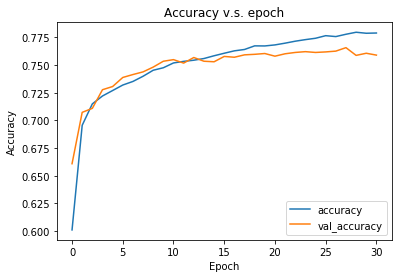

In [28]:
plot_train_metric(history, metric = "accuracy")

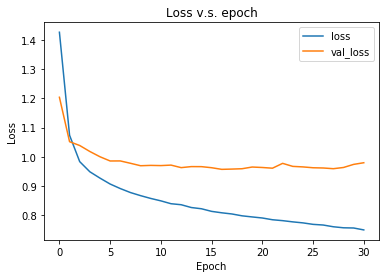

In [29]:
plot_train_metric(history, metric = "loss", loc = "upper right")